In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from PIL import Image
import cv2
import albumentations as A

import time, math
import os
from tqdm import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on Device: ", device)

Training on Device:  cuda


In [2]:
!nvidia-smi

Sat Mar 15 18:30:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             15W /  200W |    1425MiB /   8192MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import random
random_seed = 42
torch.manual_seed(random_seed)
if (device != "cpu"):
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(random_seed)
np.random.seed(random_seed)

# Предобработка

In [6]:
# синтетическое лунное изображение: 
# входное изображение --> рендер
# выходное изображение --> ground truth
IMAGE_PATH = "C:/Users/Preinstall/Downloads/U-net/dataset/train_v2/train_v5"
MASK_PATH = "C:/Users/Preinstall/Downloads/U-net/dataset/train_v2/masks_v5"
black_white = True #преобразование в оттенки серого
if (black_white): color_channels = 1
else: color_channels = 3

# Создание DataFrame

In [8]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            imname = filename.split('.')[0]
            imname = imname.replace('render','')
            name.append(imname)
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

def create_df_sorted():
    name = []
    for filename in sorted(os.listdir(IMAGE_PATH)): 
        imname = filename.split('.')[0]    
        imname = imname.replace('render','')
        name.append(imname)
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

#df = create_df()
df = create_df()
print('Total Images: ', len(df))

print(df['id'][0])
print(df['id'].values)

Total Images:  9766
0001
['0001' '0002' '0003' ... '9764' '9765' '9766']


Image Size (480, 720, 3)
Mask Size (480, 720, 3)


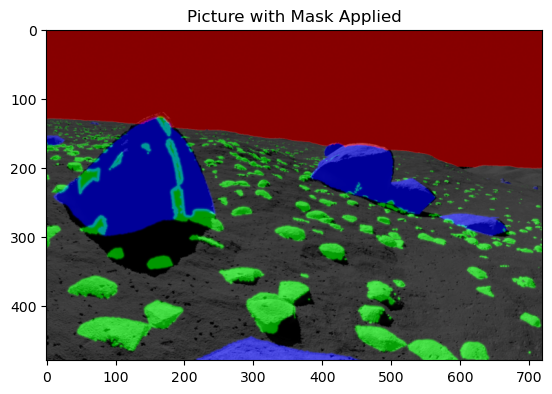

In [9]:
img = Image.open(IMAGE_PATH + 'render' + df['id'][14] + '.png')
mask = Image.open(MASK_PATH + 'ground' + df['id'][14] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.figure()
plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Applied')
plt.show()

# Разделение на Train-Val-Test

In [10]:
#разделение данных в пропорции 0.8:0.1:0.1 -> slightly changed so that train size / batch size = 16 is an integer
X_trainval, X_test = train_test_split(df['id'].values, test_size = 0.1, random_state=42, shuffle = True)
X_train, X_val = train_test_split(X_trainval, test_size = 0.1116, random_state=42, shuffle = True)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  7808
Val Size     :  981
Test Size    :  977


# Dataset

In [11]:
class FakeMoonDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        img = cv2.imread(self.img_path + 'render' + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #из BGR в RGB
        mask = cv2.imread(self.mask_path + 'ground' + self.X[idx] + '.png')
        
        #объединение маски
        mask = self.merge_moon_synth(mask)
        
        #преобразование в черно-белые метки
        mask = self.mask_to_label(mask)
        
        #трансформации
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None: img = Image.fromarray(img)
        
        #нормализация
        if (black_white): t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std), T.Grayscale()])
        else: t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask
    
    #цвета для меток в одномерном изображении
    def mask_to_label(self,mask):
        new_mask = np.zeros_like(mask[:,:,0])
        for col in range(mask.shape[2]):
            labmask = np.where(mask[:,:,col]>0,col,0)
            new_mask += labmask.astype(np.uint8)
            
        new_mask = np.where(new_mask==4,3,new_mask)
        new_mask = np.where(new_mask==5,3,new_mask)
        new_mask = np.where(new_mask==6,3,new_mask)
        
        return new_mask
    
    def merge_moon_synth(self,data):
    
        data[data > 127] = 255
        data[data <= 127] = 0

        # 0 = большие камни
        # 1 = маленькие камни
        # 2 = небо
        data_bigrocks = data[:,:,0]
        data_smallrocks = data[:,:,1]
        data_небо = data[:,:,2]

        #объединение камней
        rocks = np.logical_or(data[:,:,0],data[:,:,1]) 
        rocks = np.array(rocks, dtype = np.uint8)*255

        #черное небо в суперпозиции
        blackнебо_lines = np.logical_and(rocks, data_небо) #горизонт создает суперпозицию
        blackнебо_lines = np.array(blackнебо_lines, dtype = np.uint8)*255
        data_небо[blackнебо_lines != 0] = 0
        rocks[blackнебо_lines != 0] = 255

        # создание нового класса: местность
        data_terrain = np.logical_and(data_небо == 0, rocks == 0)
        np.shape(data_terrain)
        data_terrain = np.array(data_terrain,dtype=np.uint8)*255

        ##### новый набор данных масок
        data_new = np.zeros_like(data,dtype = np.uint8)
        data_new[:,:,0] = rocks
        data_new[:,:,1] = data_небо
        data_new[:,:,2] = data_terrain
        
        return data_new

# Вычисление среднего и стандартного отклонения

n_train = len(X_train)

#вычисление среднего
X_train_imgs_r = 0.
X_train_imgs_g = 0.
X_train_imgs_b = 0.

#вычисление стандартного отклонения
X_train_imgs_r_sq = 0.
X_train_imgs_g_sq = 0.
X_train_imgs_b_sq = 0.

n_tot = n_train*480*720

for i_train,x in enumerate(X_train):
    img = cv2.imread(IMAGE_PATH + 'render' + x + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #из BGR в RGB
    img = np.array(img,dtype = np.int64)
    
    X_train_imgs_r += np.sum(img[:,:,0])
    X_train_imgs_g += np.sum(img[:,:,1])
    X_train_imgs_b += np.sum(img[:,:,2])
    
    X_train_imgs_r_sq += np.sum(np.square(img[:,:,0]))
    X_train_imgs_g_sq += np.sum(np.square(img[:,:,1]))
    X_train_imgs_b_sq += np.sum(np.square(img[:,:,2]))
    
mean = [X_train_imgs_r/(n_tot),X_train_imgs_g/(n_tot),X_train_imgs_b/(n_tot)]

std_dev = [X_train_imgs_r_sq/(n_tot) - (mean[0]*mean[0]),
           X_train_imgs_g_sq/(n_tot) - (mean[1]*mean[1]),
           X_train_imgs_b_sq/(n_tot) - (mean[2]*mean[2])]

std_dev = np.sqrt(std_dev)

mean = np.divide(mean,255).tolist()
std_dev = np.divide(std_dev,255).tolist()
print(mean)
print(std_dev)

# Аугментация данных и Dataloaders

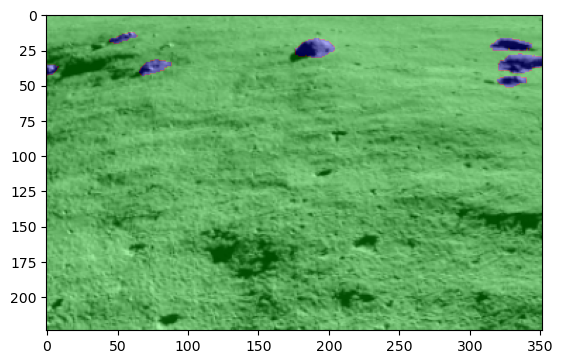

In [12]:
mean = [0.3840956136340923, 0.38397682789179083, 0.3840915669371818]
std = [0.25272097997268805, 0.2526449765088852, 0.25271917037309793]

#npix_x, npix_y = 480,704
npix_x, npix_y = 224,352

t_train = A.Compose([A.HorizontalFlip(p=0.5), 
                     A.Blur(p=0.2), #possible dust (very rare)
                     A.RandomScale(scale_limit = (0,0.1), p = 0.5), #possible distortions due to zooming (causing errors in shape...)
                     A.RandomBrightnessContrast(0.5,0.5,p = 0.5), #frequent changes because of illumination 
                     A.GaussNoise(10,p=0.3), #interference (rare)
                     A.RandomCrop(224,352,p=0.3), #crop of half the image with same ratio,
                     #A.Resize(480,704,always_apply=True,p=1) #unet needs images divisible by 32
                     A.Resize(npix_x,npix_y,always_apply=True,p=1)
                    ])

#no augmentation and mean and std devs are from training as we shouldn't know the distribution of test set in real case scenario
t_val = A.Compose([A.Resize(npix_x,npix_y,always_apply=True,p=1)])
t_test = A.Compose([A.Resize(npix_x,npix_y,always_apply=True,p=1)])

#datasets
train_set = FakeMoonDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = FakeMoonDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)
test_set = FakeMoonDataset(IMAGE_PATH, MASK_PATH, X_test, mean, std, t_test)

#plotting test
test_seg = train_set[0]
img = test_seg[0].permute(1, 2, 0)
mask = test_seg[1]

plt.figure()
plt.imshow(img, cmap = "gray")
plt.imshow(mask, alpha = 0.3, cmap = "brg")

#dataloader
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)   
test_loader = DataLoader(test_set)  

# Распределение частоты классов

# частота классов
train_count = [0,0,0] #rocks, небо and terrain
val_count = [0,0,0] #rocks, небо and terrain
test_count = [0,0,0] #rocks, небо and terrain

#all pixels
pix_train = 0
pix_val = 0
pix_test = 0

print("\n- TRAIN")
for i_train,x in enumerate(train_set):
    
    if (i_train % (int(len(train_set)/10)) == 0): print("- %i / %i" % (i_train,len(train_set)))
    data = x[1]
    
    pix_train += data.shape[0]*data.shape[1]
    train_count[0] += np.count_nonzero(data == 0)
    train_count[1] += np.count_nonzero(data == 1)
    train_count[2] += np.count_nonzero(data == 2)
    
train_count = np.divide(train_count,pix_train)
print(train_count)

print("\n- TEST")
for i_test,x in enumerate(test_set):
    
    if (i_test % (int(len(test_set)/10)) == 0): print("- %i / %i" % (i_test,len(test_set)))
    data = x[1]
    
    pix_test += data.shape[0]*data.shape[1]
    test_count[0] += np.count_nonzero(data == 0)
    test_count[1] += np.count_nonzero(data == 1)
    test_count[2] += np.count_nonzero(data == 2)

test_count = np.divide(test_count,pix_test)
print(test_count)

print("\n- VALIDATION")
for i_val,x in enumerate(val_set):
    
    if (i_val % (int(len(val_set)/10)) == 0): print("- %i / %i" % (i_val,len(val_set)))
    data = x[1]
    
    pix_val += data.shape[0]*data.shape[1]
    val_count[0] += np.count_nonzero(data == 0)
    val_count[1] += np.count_nonzero(data == 1)
    val_count[2] += np.count_nonzero(data == 2)
    
val_count = np.divide(val_count,pix_val)
print(val_count)

<Figure size 640x480 with 0 Axes>

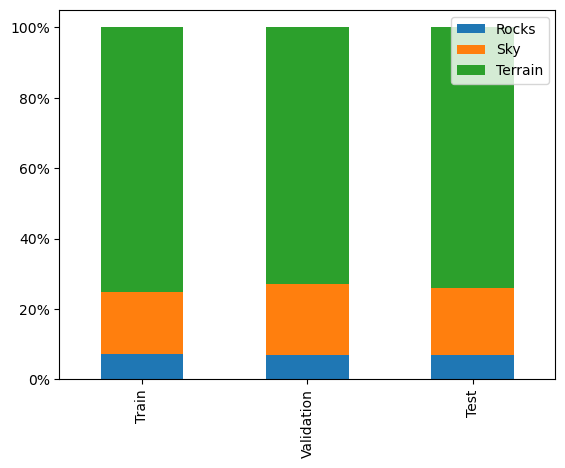

In [13]:
train_count = [0.0712635,  0.17793552, 0.75080098]
val_count = [0.06929933, 0.20140098, 0.72929969]
test_count = [0.06974799, 0.19097118, 0.73928084]

rocks_count = [train_count[0],val_count[0],test_count[0]]
небо_count = [train_count[1],val_count[1],test_count[1]]
terrain_count = [train_count[2],val_count[2],test_count[2]]

index = ['Train','Validation','Test']
df_frequency = pd.DataFrame({'Rocks': rocks_count, 'Sky': небо_count, 'Terrain': terrain_count},index)

from matplotlib.ticker import PercentFormatter
plt.figure()
df_frequency.plot.bar(stacked = True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Модели

# 1. Определение энкодера ResNet using serial and parallel adapters

In [14]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1_fonc(in_planes, out_planes=None, stride=1, bias=False):
    if out_planes is None:
        return nn.Conv2d(in_planes, in_planes, kernel_size=1, stride=stride, padding=0, bias=bias)
    else:
        return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0, bias=bias)

class conv1x1(nn.Module):
    
    def __init__(self, planes, mode, out_planes=None, stride=1):
        
        super(conv1x1, self).__init__()
        self.mode = mode
        
        if self.mode == 'series_adapters':
            self.conv = nn.Sequential(nn.BatchNorm2d(planes), conv1x1_fonc(planes))
        
        elif self.mode == 'parallel_adapters':
            self.conv = conv1x1_fonc(planes, out_planes, stride) 
        
        else:
            self.conv = conv1x1_fonc(planes)
            
    def forward(self, x):
        y = self.conv(x)
        if self.mode == 'series_adapters':
            y += x
        return y

#adapter module!
class conv_task(nn.Module):
    
    def __init__(self, in_planes, planes, mode, stride=1, is_proj=1, second=0):
        super(conv_task, self).__init__()
        self.is_proj = is_proj
        self.second = second #every residual skip connection has two conv blocks
        self.conv = conv3x3(in_planes, planes, stride)
        self.mode = mode #series or parallel
        
        if self.mode == 'series_adapters' and self.is_proj:
            self.bns = nn.Sequential(conv1x1(planes, mode), nn.BatchNorm2d(planes))
        elif self.mode == 'parallel_adapters' and self.is_proj:
            self.parallel_conv = conv1x1(in_planes, mode, planes, stride)
            self.bns = nn.BatchNorm2d(planes)
        else:
            self.bns = nn.BatchNorm2d(planes)
    
    def forward(self, x):
        
        y = self.conv(x)
        
        if self.second == 0: x = F.dropout2d(x, p=0.5, training = self.training)
        else: x = F.dropout2d(x, p=0.5, training = self.training)
        
        if self.mode == 'parallel_adapters' and self.is_proj: y = y + self.parallel_conv(x)
        y = self.bns(y)

        return y

#changing the basic block of resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, mode, stride=1, downsample = None):
        super(BasicBlock, self).__init__()
        
        self.mode = mode #series, parallel or none
        
        self.conv1 = conv_task(in_planes, planes, self.mode, stride, is_proj= 1) 
        self.conv2 = nn.Sequential(nn.ReLU(True), conv_task(planes, planes, self.mode, 1, is_proj = 1, second=1))
        
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        y = self.conv1(x)
        y = self.conv2(y)
        
        if self.downsample is not None:
            residual = self.downsample(x)

        y += residual
        y = F.relu(y)
        return y


class ResNetEncoder_Adapter(nn.Module):

    def __init__(self, block, nblocks, mode, color_channels = 3):
        super(ResNetEncoder_Adapter, self).__init__()

        self.mode = mode
        blocks = [block, block, block, block] #4 main blocks!
        self.in_planes = 64
        self.output_stride = 32 #need it to check input size in model, which requires height and wodth divisible by 32
        
        self.conv1 = nn.Conv2d(color_channels, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(blocks[0], 64, nblocks[0], stride=1)
        self.layer2 = self._make_layer(blocks[1], 128, nblocks[1], stride=2)
        self.layer3 = self._make_layer(blocks[2], 256, nblocks[2], stride=2)
        self.layer4 = self._make_layer(blocks[3], 512, nblocks[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, nblocks, stride = 1):
        
        downsample = None
        
        if stride != 1 or self.in_planes != planes * block.expansion:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
            
        layers = []
        layers.append(block(self.in_planes, planes, self.mode, stride, downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, nblocks):
            layers.append(block(self.in_planes, planes, self.mode))
        return nn.Sequential(*layers)
    
    def get_stages(self): #нужны для последующего использования с блоками декодера
        
        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):
        
        stages = self.get_stages()

        features = []
        for i in range(6):
            x = stages[i](x)
            features.append(x)

        return features

# 2. Определение UNet с энкодером ResNet with adapters

In [15]:
from typing import Optional, Union, List
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
from segmentation_models_pytorch.decoders.unet.decoder import *

In [16]:
class Unet_Adapters(SegmentationModel):

    def __init__(
        self,
        encoder_adapt,
        encoder_channels,
        encoder_depth,
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = encoder_adapt
        
        self.decoder = UnetDecoder(
            encoder_channels = encoder_channels,
            decoder_channels = decoder_channels,
            n_blocks = encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        else:
            self.classification_head = None

        self.name = "u-resnet18-adapt"
        self.initialize()

# 3. Определение моделей сегментации UNet

In [17]:
#no adapters...
unet = smp.Unet('resnet18', decoder_channels = (256, 128, 64, 32, 16), classes = 3, activation = None, in_channels = color_channels)

#new encoders with adapters
encoder_adapt_series = ResNetEncoder_Adapter(BasicBlock, [2,2,2,2], "series_adapters", color_channels)
encoder_adapt_parall = ResNetEncoder_Adapter(BasicBlock, [2,2,2,2], "parallel_adapters", color_channels)

#new segmentation unets
unet_adapt_series = Unet_Adapters(encoder_adapt_series, (color_channels, 64, 64, 128, 256, 512), 5, decoder_channels = (256, 128, 64, 32, 16), classes = 3, activation = None)
unet_adapt_parall = Unet_Adapters(encoder_adapt_parall, (color_channels, 64, 64, 128, 256, 512), 5, decoder_channels = (256, 128, 64, 32, 16), classes = 3, activation = None)

# Перенос весов

In [18]:
#get state dictionary of all childrens on list
def get_pars_child(child):
    
    global par_list
    subchildrens = child.children()
    n_childrens = len(list(subchildrens))
    
    #no other subchildren...
    if (n_childrens == 0): par_list.append(child.state_dict())
        
    else: #other childrens...
        
        for subchild in child.children(): 
            get_pars_child(subchild) #recursive call

In [19]:
#transfer weights
def transfer_weights(child, state_dict, adapters):
    
    global ichild,icopy
    subchildrens = child.children()
    n_childrens = len(list(subchildrens))
    
    #no other subchildren...
    if (n_childrens == 0):
        
        if not(ichild in adapters):
            print("Copying Parameter in child ", child, " %i from %i" % (ichild,icopy))
            child.load_state_dict(state_dict[icopy])
            icopy = icopy + 1

        #global counter
        ichild = ichild + 1
        
    else: #other childrens...
        
        for subchild in child.children(): 
            transfer_weights(subchild,state_dict,adapters) #recursive call

In [20]:
'''
unet_smob,history_smob = torch.load('/kaggle/input/advanceddl-trained-models/Unet_baseline_smob.pt')
par_list = []
for child in (unet_smob.get_submodule("encoder").children()): 
    get_pars_child(child)
'''

'\nunet_smob,history_smob = torch.load(\'/kaggle/input/advanceddl-trained-models/Unet_baseline_smob.pt\')\npar_list = []\nfor child in (unet_smob.get_submodule("encoder").children()): \n    get_pars_child(child)\n'

In [21]:
par_list = []
for child in (unet.get_submodule("encoder").children()): #imagenet weights
    get_pars_child(child)

In [22]:
unet_adapt_series.eval() #copying in ev mode
par_adapters = [6, 11, 15, 20, 24, 29, 35, 40, 44, 49, 55, 60, 64, 69, 75, 80, 5, 10, 14, 19, 23, 28, 34, 39, 43, 48, 54, 59, 63, 68, 74, 79]

#copying encoder
ichild,icopy = 0,0
for child in (unet_adapt_series.get_submodule("encoder").children()): 
    transfer_weights(child,par_list,par_adapters)
    
unet_adapt_series.get_submodule("decoder").load_state_dict(unet.get_submodule("decoder").state_dict())
unet_adapt_series.get_submodule("segmentation_head").load_state_dict(unet.get_submodule("segmentation_head").state_dict())

#copying decoder and segmentation head
#unet_adapt_series.get_submodule("decoder").load_state_dict(unet_smob.get_submodule("decoder").state_dict())
#unet_adapt_series.get_submodule("segmentation_head").load_state_dict(unet_smob.get_submodule("segmentation_head").state_dict())
#torch.save((unet_adapt_series,history_smob),'/kaggle/working/Unet_baseline_smob_adapt_series.pt')

Copying Parameter in child  Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  0 from 0
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  1 from 1
Copying Parameter in child  ReLU(inplace=True)  2 from 2
Copying Parameter in child  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)  3 from 3
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  4 from 4
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  7 from 5
Copying Parameter in child  ReLU(inplace=True)  8 from 6
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  9 from 7
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  12 from 8
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(

<All keys matched successfully>

In [23]:
unet_adapt_parall.eval() #copying in ev mode
par_adapters = [5,9,12,16,19,23,28,32,35,39,44,48,51,55,60,64]

#copying encoder
ichild,icopy = 0,0
for child in (unet_adapt_parall.get_submodule("encoder").children()): 
    transfer_weights(child,par_list,par_adapters)
    
unet_adapt_parall.get_submodule("decoder").load_state_dict(unet.get_submodule("decoder").state_dict())
unet_adapt_parall.get_submodule("segmentation_head").load_state_dict(unet.get_submodule("segmentation_head").state_dict())

#copying decoder and segmentation head
#unet_adapt_parall.get_submodule("decoder").load_state_dict(unet_smob.get_submodule("decoder").state_dict())
#unet_adapt_parall.get_submodule("segmentation_head").load_state_dict(unet_smob.get_submodule("segmentation_head").state_dict())
#torch.save((unet_adapt_parall,history_smob),'/kaggle/working/Unet_baseline_smob_adapt_parall.pt')

Copying Parameter in child  Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  0 from 0
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  1 from 1
Copying Parameter in child  ReLU(inplace=True)  2 from 2
Copying Parameter in child  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)  3 from 3
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  4 from 4
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  6 from 5
Copying Parameter in child  ReLU(inplace=True)  7 from 6
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  8 from 7
Copying Parameter in child  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  10 from 8
Copying Parameter in child  Conv2d(64, 64, kernel_size=(3, 3), stride=(

<All keys matched successfully>

In [24]:
#choosing which one to train
unet_train = unet

# Метрики

In [25]:
import sklearn.metrics as metrics 
metric_names = ["Accuracy","Balanced Accuracy","Jaccard Score"]

In [26]:
#modifying balanced accuracy
def balanced_accuracy_score(y_true, y_pred):
    
    #должны использовать метки = [0,1,2]
    C = metrics.confusion_matrix(y_true, y_pred, labels = [0,1,2])
    
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class = np.diag(C) / C.sum(axis=1) #tp/(tp+fn)
        
    for irec,rec in enumerate(per_class):
        #label is not in ground truth and is not predicted
        if (np.isnan(rec) and C.sum(axis=0)[irec] == 0): rec = 1 #no true pos, no true neg and no false positive
   
    #if there are false positives but no false negative and true positive remains nan
    per_class = per_class[~np.isnan(per_class)]
    
    score = np.nanmean(per_class)
    return score

In [27]:
def pixel_metrics(output, mask, metric = "acc"):
    
    with torch.no_grad():
            
        #applying softmax and choosing best class with argmax
        output = F.softmax(output, dim=1) #on all colors
        output = torch.argmax(output, dim=1) #on all colors

        #need 1d vectors for sklearn.metrics -> need cpu to convert to numpy 
        output = output.cpu().contiguous().view(-1) #1d
        mask = mask.cpu().contiguous().view(-1) #1d
        
    if (metric == "Accuracy"): return metrics.accuracy_score(mask,output)
    #if (metric == "Balanced Accuracy"): return metrics.balanced_accuracy_score(mask,output)
    if (metric == "Balanced Accuracy"): return balanced_accuracy_score(mask,output)
    if (metric == "Матрица ошибок"): return metrics.confusion_matrix(mask,output,labels = [0,1,2])
    if (metric == "Jaccard Score"): return metrics.jaccard_score(mask,output,average = "macro",zero_division = 1)
    else: 
        print("Metric not found...")
        return None

In [28]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizers, schedulers, stopat = None):
    
    torch.cuda.empty_cache()
    
    train_losses = []
    test_losses = []
    
    train_metrics = []
    test_metrics = []
    
    lrs = [] #list of all learning rates for each epoch e.g. [[0.001,0.005,0.01],[0.0009,0.004,0.009],...]
    
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        
        train_metr_epoch = [0,0,0]
        test_metr_epoch = [0,0,0]
        lr_list = [] #learning rate for each optimizer e.g. [0.001,0.005,0.01]
        
        #training loop
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            
            if (stopat is not None and i == stopat): break
            
            #training phase
            image, mask = data
            
            image = image.to(device)
            mask = mask.to(device)
            
            #forward
            output = model(image)
            loss = criterion(output, mask)
            
            #evaluation metrics
            for imetr,metr in enumerate(metric_names):
                train_metr_epoch[imetr] += pixel_metrics(output,mask,metr)
            
            #backward
            loss.backward()
            
            for optimizer in optimizers:
                
                optimizer.step() #update weight          
                optimizer.zero_grad() #reset gradient
            
                #step the learning rate
                if (i==0): lr_list.append(get_lr(optimizer)) #need it only for first element of dataloader
                    
            running_loss += loss.item()
            
        #end training 
        
        #step the learning rate
        lrs.append(lr_list)
        
        #scheduler step at each epoch
        for scheduler in schedulers:
            if (scheduler is not None): scheduler.step()
        
        #start evaluation
        model.eval()
        test_loss = 0.
        
        #validation loop
        with torch.no_grad():
            
            for i, data in enumerate(tqdm(val_loader)):
                
                if (stopat is not None and i == stopat): break
                
                image, mask = data
                image = image.to(device)
                mask = mask.to(device)
                
                #forward
                output = model(image)
                loss = criterion(output, mask)  
                
                #evaluation metrics
                for imetr,metr in enumerate(metric_names):
                    test_metr_epoch[imetr] += pixel_metrics(output,mask,metr)
                    
                test_loss += loss.item()

        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))
        
        train_metrics.append(np.divide(train_metr_epoch,len(train_loader)).tolist())
        test_metrics.append(np.divide(test_metr_epoch,len(val_loader)).tolist())

        if min_loss > (test_loss/len(val_loader)):
            
            print('Loss Decreasing for {:}-th Time {:.3f} >> {:.3f} '.format(decrease, min_loss, (test_loss/len(val_loader))))
            min_loss = (test_loss/len(val_loader))
            decrease += 1
        
            #saving every 5 decrease
            #if decrease % 5 == 0:
            #    print('Saving model...')
            #    torch.save(model, 'Unet-{decrease}.pt')

        if (test_loss/len(val_loader)) > min_loss:
            
            not_improve += 1
            min_loss = (test_loss/len(val_loader))
            print('Loss Not Decreasing for {}-th Time'.format(not_improve))
            
            if not_improve == 7:
                print('Loss not decreasing for 7 times, Stop Training')
                #break
                
        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss/len(val_loader)))
        
        for imetr,metr in enumerate(metric_names):
            print("Train " + metr + ": {:.3f}".format(train_metrics[e][imetr]))
            print("Val " + metr + ": {:.3f}".format(test_metrics[e][imetr]))
            
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_metric' : train_metrics, 'val_metric': test_metrics,
               'lrs': lrs}
    
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

# Обучение базового UNet

In [ ]:
#max_lr = 1e-2
max_lr = 1e-3 #best one!
#max_lr = 1e-4 

epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
#optimizer_encoder = torch.optim.AdamW(unet_train.get_submodule("encoder").parameters(), lr=max_lr, weight_decay=weight_decay)
#optimizer_decoder = torch.optim.AdamW(unet_train.get_submodule("decoder").parameters(), lr=max_lr, weight_decay=weight_decay)
#optimizer_seghead = torch.optim.AdamW(unet_train.get_submodule("segmentation_head").parameters(), lr=max_lr, weight_decay=weight_decay)

optimizer_encoder = torch.optim.SGD(unet_train.get_submodule("encoder").parameters(), lr=max_lr/5., momentum = 0.9)
optimizer_decoder = torch.optim.SGD(unet_train.get_submodule("decoder").parameters(), lr=max_lr, momentum = 0.9)
optimizer_seghead = torch.optim.SGD(unet_train.get_submodule("segmentation_head").parameters(), lr=max_lr, momentum = 0.9)
optimizer = [optimizer_encoder,optimizer_decoder,optimizer_seghead]

#optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
'''
sched_encoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_encoder, gamma = 0.93) #0.1 factor every 30 epochs
sched_decoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma = 0.93)
sched_seghead = torch.optim.lr_scheduler.ExponentialLR(optimizer_seghead, gamma = 0.93)
sched = [sched_encoder,sched_decoder,sched_seghead]
'''

sched_encoder = None
sched_decoder = None
sched_seghead = None
sched = [sched_encoder,sched_decoder,sched_seghead]

'''
sched_encoder = torch.optim.lr_scheduler.StepLR(optimizer_encoder, step_size = 3, gamma = 0.79)
sched_decoder = torch.optim.lr_scheduler.StepLR(optimizer_decoder, step_size = 3, gamma = 0.79)
sched_seghead = torch.optim.lr_scheduler.StepLR(optimizer_seghead, step_size = 3, gamma = 0.79)
sched = [sched_encoder,sched_decoder,sched_seghead]
'''

history = fit(epoch, unet_train, train_loader, val_loader, criterion, optimizer, sched)

a


 98%|█████████▊| 61/62 [01:14<00:01,  1.16s/it]C:\Users\Preinstall\.conda\envs\ML\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 62/62 [01:14<00:00,  1.20s/it]


Loss Decreasing for 1-th Time inf >> 0.220 
Epoch:1/10.. Train Loss: 0.287.. Val Loss: 0.220..
Train Accuracy: 0.907
Val Accuracy: 0.924
Train Balanced Accuracy: 0.652
Val Balanced Accuracy: 0.682
Train Jaccard Score: 0.598
Val Jaccard Score: 0.645
a


  2%|▏         | 10/488 [00:13<11:01,  1.38s/it]

In [30]:
!pip install ipywidgets

In [ ]:
# saving model
torch.save((unet_train,history),'/kaggle/working/Unet.pt')

In [61]:
# loading model
unet_load,history_load = torch.load('C:/Users/Preinstall/Downloads/models/Unet_baseline_smob.pt')

In [62]:
def plot_loss(history):
    
    plt.figure()
    plt.plot(history['val_loss'], label='Потери на проверочном наборе данных', marker='o', color = "blue", linestyle = "dashed")
    plt.plot(history['train_loss'], label='Потери на тренировочном наборе данных', marker='o', color = "green",linestyle = "dashed")
    plt.title('Потери по эпохам')
    plt.ylabel('Потери при категориальной кросс-энтропии');
    plt.xlabel('Эпоха')
    plt.legend(loc = "best")
    plt.grid()
    plt.show()
    
def plot_score(history):
    
    for imetr,metr in enumerate(metric_names):
        
        train_score = [history['train_metric'][e][imetr] for e in range(len(history['train_metric']))] 
        val_score = [history['val_metric'][e][imetr] for e in range(len(history['val_metric']))] 
        
        plt.figure()
        plt.plot(train_score, label = metr + " на тренировочном наборе данных", marker='o', color = "green", linestyle = "dashed")
        plt.plot(val_score, label = metr + " на проверочном наборе данных", marker='o', color = "blue",linestyle = "dashed")
        plt.title('Потери на эпохе')
        plt.ylabel("Средняя " + metr)
        plt.xlabel('Эпоха')
        plt.legend(loc = "best")
        plt.grid()
        plt.show()

def plot_lrs(history):
    
    nlrs = len(history['lrs'][0])
    lr_epoch = []
    colors = ["r","g","b","c","m","y"]
    labels = ["Encoder","Decoder","Segmentation Head"]
    
    for ilr in range(nlrs):
        lr_epoch.append([history['lrs'][e][ilr] for e in range(len(history['lrs']))])
        
    plt.figure()
    for ilr in range(nlrs):
        plt.plot(lr_epoch[ilr], marker='o', color = colors[ilr], label = labels[ilr], linestyle = "dashed")
    plt.title('Learning Rates per epoch')
    plt.ylabel("Learning Rate")
    plt.xlabel('Epoch')
    #plt.yscale("log")
    plt.legend(loc = "best")
    plt.grid()
    plt.show()

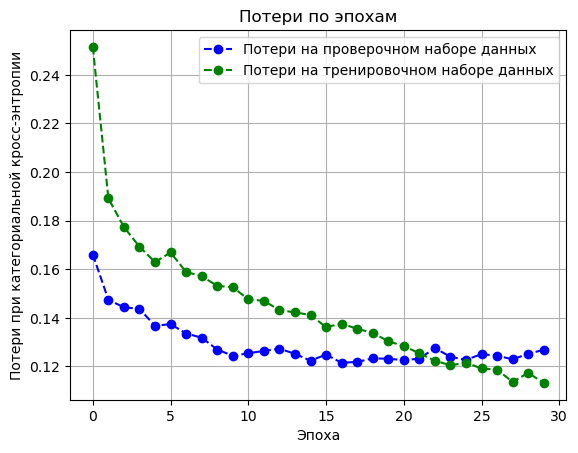

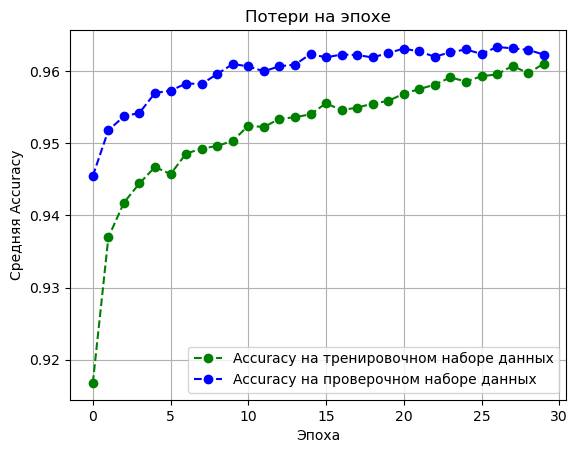

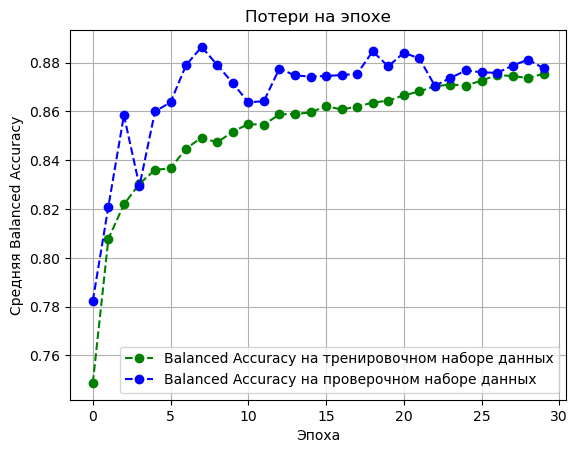

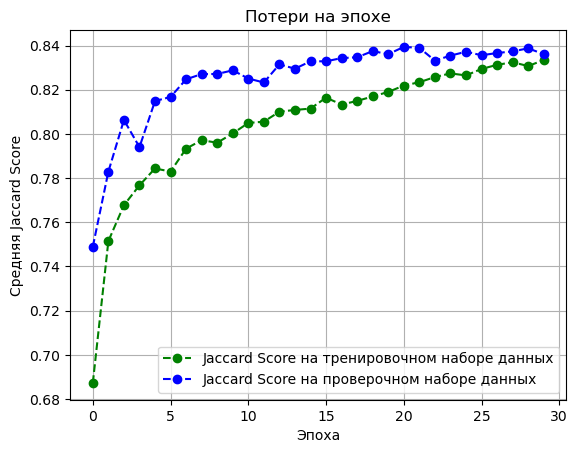

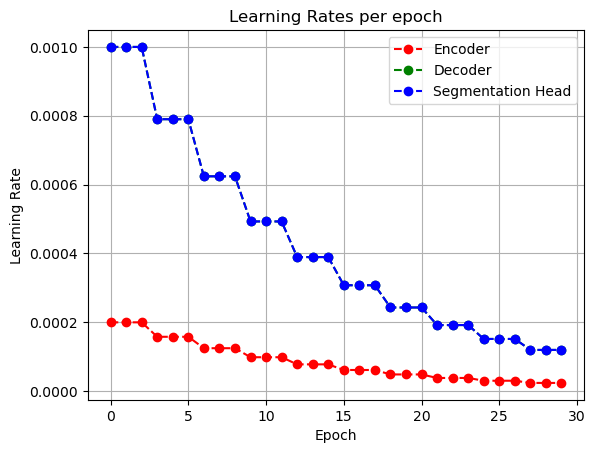

In [63]:
plot_loss(history_load)
plot_score(history_load)
plot_lrs(history_load)

# Оценка на тестовом наборе of Baseline U-Net

In [64]:
def evaluate(model):

    model.eval()
    model.to(device)
    confusion_matrix = np.zeros((3,3))
    test_metrics = [[],[],[]]

    with torch.no_grad():    
        
        for i, data in enumerate(tqdm(test_loader)):
            
            image, mask = data
            image = image.to(device)
            mask = mask.to(device)
            
            #image = image.unsqueeze(0)
            #mask = mask.unsqueeze(0)

            #forward
            output = model(image)  

            #evaluation metrics
            for imetr,metr in enumerate(metric_names):
                test_metrics[imetr].append(pixel_metrics(output,mask,metr))

            if (np.array(pixel_metrics(output,mask,"Матрица ошибок").shape != (3,3))): 
                print(np.array(pixel_metrics(output,mask,"Матрица ошибок")))
            
            
            confusion_matrix += np.array(pixel_metrics(output,mask,"Матрица ошибок"))
            
            #output = output.cpu().squeeze(0)
    return test_metrics, confusion_matrix

In [65]:
scores, conf_matrix = evaluate(unet_load)

  0%|          | 0/977 [00:00<?, ?it/s]

# 1. Матрица ошибок 

Text(0.5, 23.52222222222222, 'Предположение модели')

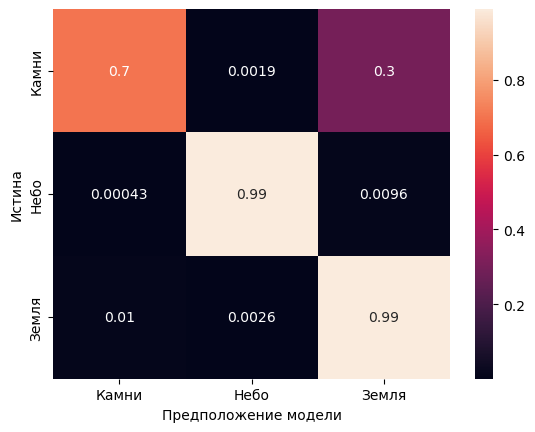

In [66]:
import seaborn as sns
from sklearn.preprocessing import normalize
normed_matrix = normalize(conf_matrix, axis=1, norm='l1')
plt.figure()
sns.heatmap(pd.DataFrame(normed_matrix.tolist(),columns = ["Камни","Небо","Земля"],index = ["Камни","Небо","Земля"]), annot = True)
plt.ylabel("Истина")
plt.xlabel("Предположение модели")


Text(0.5, 23.52222222222222, 'Predicted Labels')

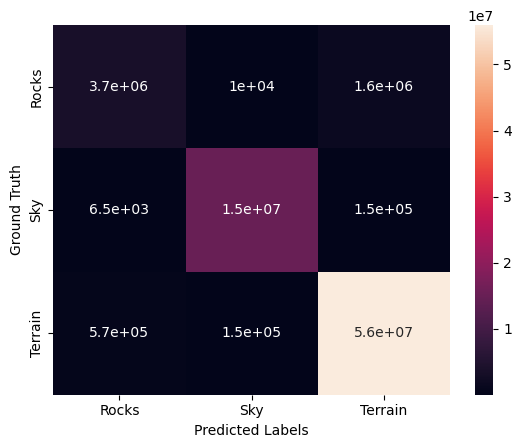

In [67]:
sns.heatmap(pd.DataFrame(conf_matrix.tolist(),columns = ["Rocks","Sky","Terrain"],index = ["Rocks","Sky","Terrain"]), annot = True)
plt.ylabel("Ground Truth")
plt.xlabel("Predicted Labels")

# 2. Точность, сбалансированная точность и коэффициент Жаккара

In [68]:
acc = scores[0]
bal_acc = scores[1]
jacc_score = scores[2]

print("Accuracy: {:.2f}".format(np.mean(acc)))
print("Balanced Accuracy: {:.2f}".format(np.mean(bal_acc)))
print("Jaccard Score: {:.2f}".format(np.mean(jacc_score)))

Accuracy: 0.97
Balanced Accuracy: 0.85
Jaccard Score: 0.82


In [69]:
def predicted_mask(model,image):
    
    image = image.to(device)
    output = model(image)
    
    #applying softmax and choosing best class with argmax
    output = F.softmax(output, dim=1) #on all colors
    output = torch.argmax(output, dim=1) #on all colors
    
    return output

In [81]:
ibest = bal_acc.index(max(bal_acc))
iworst = bal_acc.index(min(bal_acc))
irandom = random.randint(0,len(test_loader)-1)

image_best = test_set[ibest][0]
image_worst = test_set[iworst][0]
image_rndm = test_set[irandom][0]

mask_best = test_set[ibest][1]
mask_worst = test_set[iworst][1]
mask_rndm = test_set[irandom][1]
        
predicted_best = predicted_mask(unet_load,image_best.view(1,1,npix_x,npix_y))
predicted_worst = predicted_mask(unet_load,image_worst.view(1,1,npix_x,npix_y))
predicted_random = predicted_mask(unet_load,image_rndm.view(1,1,npix_x,npix_y))

Text(0.5, 1.0, 'Image with U-Net Prediction (Random)')

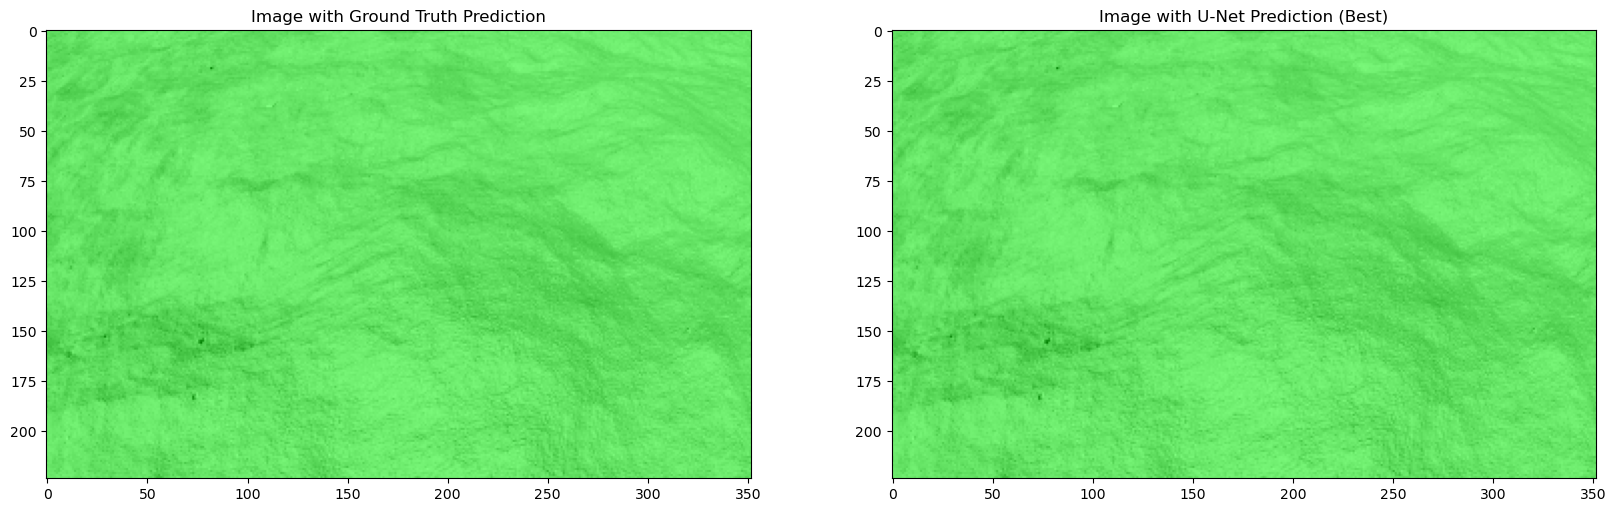

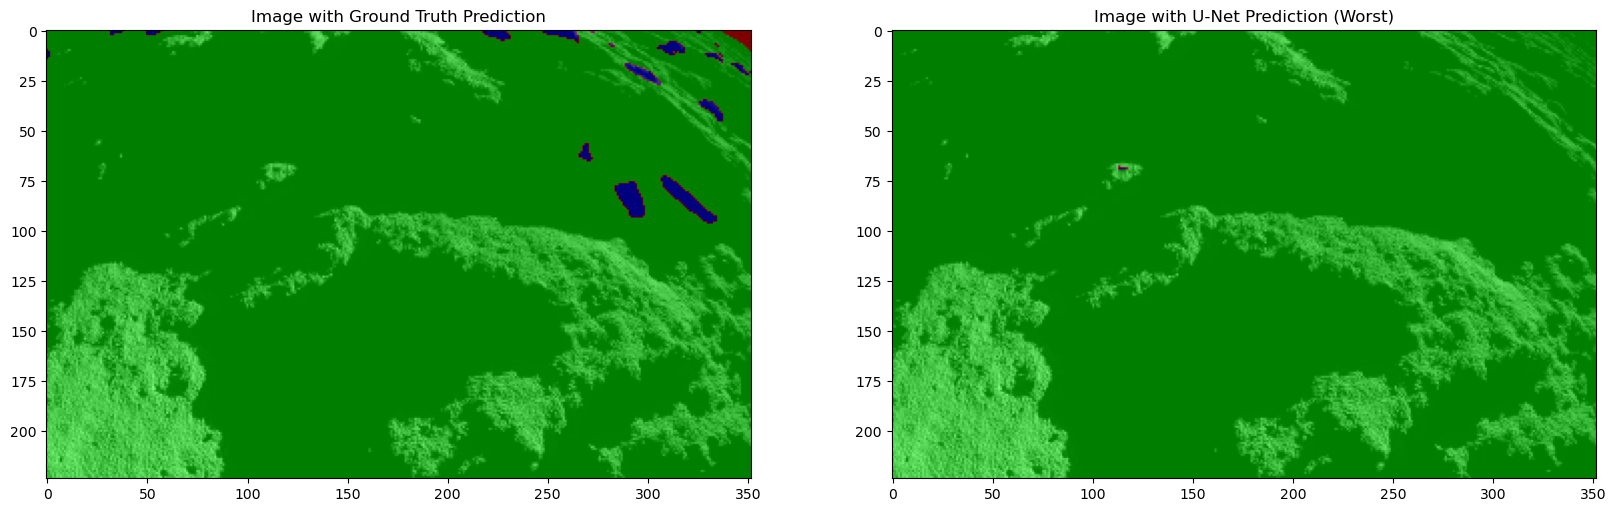

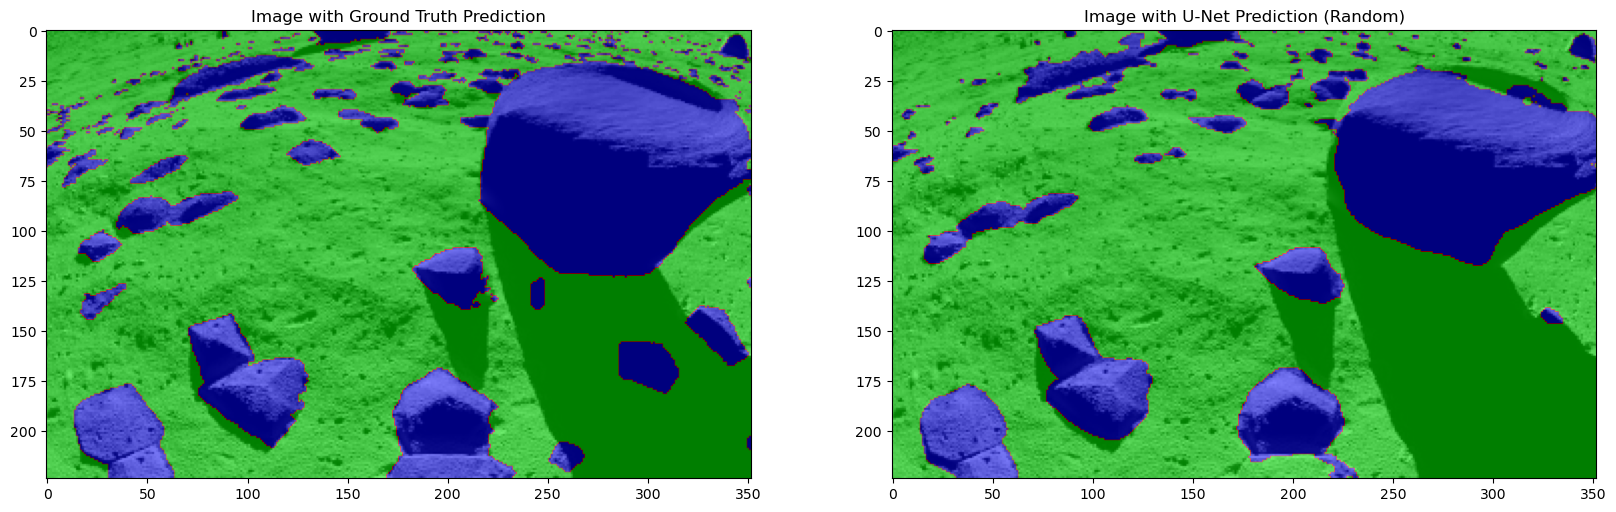

In [82]:
#best prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_best.permute(1, 2, 0), cmap = "gray")
ax[0].imshow(mask_best, alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_best.permute(1, 2, 0), cmap = "gray")
ax[1].imshow(predicted_best.cpu().view(npix_x,npix_y), alpha = 0.5, cmap = "brg",vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Best)')

#worst prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_worst.permute(1, 2, 0), cmap = "gray")
ax[0].imshow(mask_worst, alpha = 0.5,cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_worst.permute(1, 2, 0), cmap = "gray")
ax[1].imshow(predicted_worst.cpu().view(npix_x,npix_y), alpha = 0.5,cmap = "brg", vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Worst)')

#random prediction
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].imshow(image_rndm.permute(1, 2, 0),cmap="gray")
ax[0].imshow(mask_rndm, alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[0].set_title('Image with Ground Truth Prediction')

ax[1].imshow(image_rndm.permute(1, 2, 0),cmap="gray")
ax[1].imshow(predicted_random.cpu().view(npix_x,npix_y), alpha = 0.5, cmap = "brg", vmin = 0, vmax = 2)
ax[1].set_title('Image with U-Net Prediction (Random)')

# Сравнение различных моделей

In [41]:
unet_1,history_1 = torch.load('C:/Users/Preinstall/Downloads/models/Unet_baseline_smob.pt')
unet_2,history_2 = torch.load('C:/Users/Preinstall/Downloads/models/Unet_adapt_smob_parall.pt')
unet_3,history_3 = torch.load('C:/Users/Preinstall/Downloads/models/Unet_adapt_smob_series.pt')

histories = [history_1,history_2,history_3]
models= [unet_1,unet_2,unet_3]
names = ["Unet_Baseline","Unet_Adapters_Parallel","Unet_Adapters_Series"]

In [62]:
#functions to compare results
def plot_loss_compare(histories,labels,lasts = None):
    
    colors = ["r","g","b","c","m","y"]
    
    plt.figure()
    for ih,history in enumerate(histories):
        
        n_epochs_plot = len(history['val_loss'])
        start_epoch = 0
        if (lasts): start_epoch = n_epochs_plot - lasts
        plt.plot(history['val_loss'][start_epoch:n_epochs_plot], 
                 label = labels[ih], 
                 marker='o', 
                 color = colors[ih], 
                 linestyle = "dashed")
    
    plt.title('Потери на проверочном наборе данных по эпохам')
    plt.ylabel('Потери при категориальной кросс-энтропии');
    plt.xlabel('Эпоха')
    plt.legend(loc = "best")
    plt.grid()
    plt.show()
    
def plot_score_compare(histories,labels,lasts = None):
    
    colors = ["r","g","b","c","m","y"]
    
    for imetr,metr in enumerate(metric_names):
        
        plt.figure()
        for ih,history in enumerate(histories): 
            
            n_epochs_plot = len(history['val_metric'])
            start_epoch = 0
            if (lasts): start_epoch = n_epochs_plot - lasts
            val_score = [history['val_metric'][e][imetr] for e in range(start_epoch,n_epochs_plot)] 
            plt.plot(val_score, label = labels[ih], marker='o', color = colors[ih],linestyle = "dashed")
        print(metr)
        plt.title(metr + ' на проверочном наборе данных по эпохам')
        plt.ylabel("Средняя " + metr)
        plt.xlabel('Эпоха')
        plt.legend(loc = "best")
        plt.grid()
        plt.show()
    

In [63]:
print("Accuracy","Balanced Accuracy","IOU")
for ih,history in enumerate(histories):
    print("%.4f & %.4f & %.4f \\" % (history['val_metric'][-1][0],history['val_metric'][-1][1],history['val_metric'][-1][2]))

Accuracy Balanced Accuracy IOU
0.9623 & 0.8776 & 0.8361 \
0.9582 & 0.8636 & 0.8193 \
0.9592 & 0.8686 & 0.8241 \


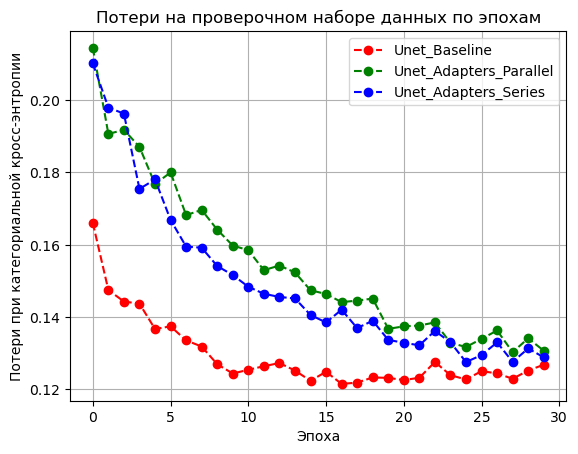

Точность


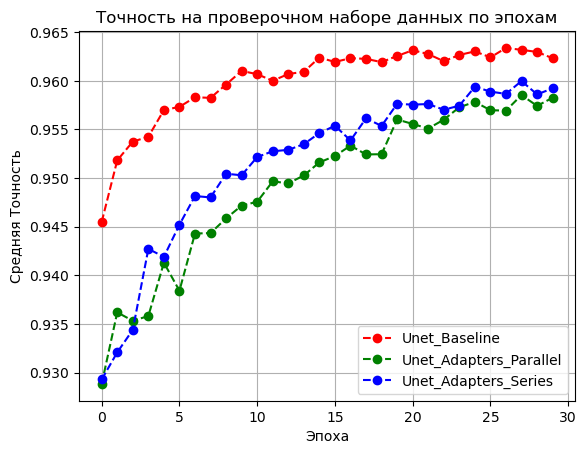

Сбалансированная точность


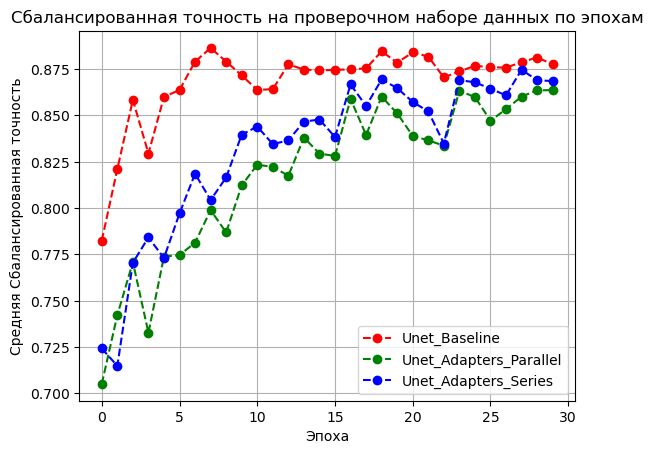

Коэффициент Жаккара


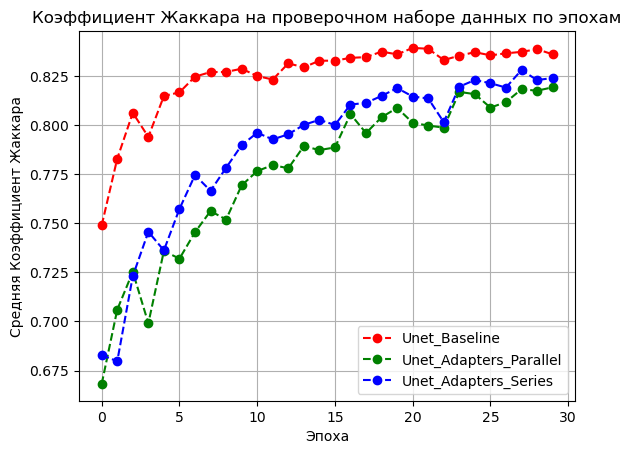

In [64]:
plot_loss_compare(histories,names)
plot_score_compare(histories,names)

# MACs

In [48]:
! pip install ptflops
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    
    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y))
    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y), ignore_modules = [torch.nn.BatchNorm2d])

    #macs, params = get_model_complexity_info(unet_adapt_parall, (1, npix_x, npix_y))
    macs, params = get_model_complexity_info(unet_adapt_series, (1, npix_x, npix_y))
    #macs, params = get_model_complexity_info(unet, (1, npix_x, npix_y), ignore_modules = [torch.nn.Conv2d,torch.nn.ReLU])
    
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Unet_Adapters(
  15.72 M, 100.000% Params, 6.75 GMac, 99.819% MACs, 
  (encoder): ResNetEncoder_Adapter(
    12.57 M, 79.952% Params, 3.07 GMac, 45.347% MACs, 
    (conv1): Conv2d(3.14 k, 0.020% Params, 61.82 MMac, 0.914% MACs, 1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, 0.001% Params, 2.52 MMac, 0.037% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 1.26 MMac, 0.019% MACs, inplace=True)
    (maxpool): MaxPool2d(0, 0.000% Params, 1.26 MMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      164.86 k, 1.049% Params, 813.08 MMac, 12.028% MACs, 
      (0): BasicBlock(
        82.43 k, 0.524% Params, 406.54 MMac, 6.014% MACs, 
        (conv1): conv_task(
          41.22 k, 0.262% Params, 203.11 MMac, 3.005% MACs, 
          (conv): Conv2d(36.86 k, 0.234% Params, 181.67 MMac, 2.687% MACs, 64, 64, kernel_size=(3, 3), str

In [49]:
import torchviz
dot = torchviz.make_dot(

SyntaxError: unexpected EOF while parsing (697069252.py, line 2)

In [54]:
import torch
import torch.nn as nn
import onnx  # Убедитесь, что библиотека onnx установлена
import os
import netron

# Определяем простую нейронную сеть
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Создаем модель
model = SimpleNN()

# Создаем случайный входной тензор
x = torch.randn(1, 784)

# Экспорт модели в формат ONNX
onnx_path = "model.onnx"
torch.onnx.export(unet_1, image_best.view(1,1,npix_x,npix_y).to('cuda'), onnx_path, export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

print(f"Модель успешно экспортирована в формат ONNX по пути {onnx_path}.")

# Открытие модели с помощью Netron (если Netron установлен через pip)
netron.start(onnx_path)


C:\Users\Preinstall\.conda\envs\ML\lib\site-packages\torch\onnx\symbolic_helper.py:833: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


Модель успешно экспортирована в формат ONNX по пути model.onnx.
Serving 'model.onnx' at http://localhost:8080


('localhost', 8080)

In [55]:
import torch
import torch.nn as nn
import onnx  # Убедитесь, что библиотека onnx установлена
import os
import netron

# Определяем простую нейронную сеть
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Создаем модель
model = SimpleNN()

# Создаем случайный входной тензор
x = torch.randn(1, 784)

# Экспорт модели в формат ONNX
onnx_path = "model.onnx"
torch.onnx.export(unet_2, image_best.view(1,1,npix_x,npix_y).to('cuda'), onnx_path, export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

print(f"Модель успешно экспортирована в формат ONNX по пути {onnx_path}.")

# Открытие модели с помощью Netron (если Netron установлен через pip)
netron.start(onnx_path)


Модель успешно экспортирована в формат ONNX по пути model.onnx.
Serving 'model.onnx' at http://localhost:8080


('localhost', 8080)